In [6]:
using Pkg; Pkg.activate()
using LinearAlgebra

using Revise
using CarbonNetworks

In [116]:
using LightGraphs, Random, Distributions

Random.seed!(2)
n = 5

# Make graph
G = watts_strogatz(n, 4, 0.2)

# Convert to incidence matrix
A = incidence_matrix(G, oriented=true)
m = size(A, 2)

@show (n, m)

# Generate costs
f = rand(Exponential(5), n) .+ 5

# Generate generation and flow capacities
gmax = rand(Gamma(5.0, 5.0), n)
pmax = rand(Gamma(1.0, 1.0), m)

@show maximum(gmax)
@show maximum(pmax)

# Generate demands
d = rand(Uniform(0.5, 1.0), n) .* gmax;

(n, m) = (5, 10)
maximum(gmax) = 35.45965977604071
maximum(pmax) = 3.89892377681955


In [117]:
using ECOS

params = (f, d, pmax, gmax, A)
opf = PowerManagementProblem(params...)
solve!(opf, () -> ECOS.Optimizer(verbose=true))


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -1.808e+02  +7e+02  3e-01  9e-02  1e+00  2e+01    ---    ---    1  1  - |  -  - 
 1  +2.858e+01  -8.306e+02  +7e+02  2e+00  3e-01  2e+01  2e+01  0.1473  8e-01   1  1  1 |  0  0
 2  +4.507e+01  +9.458e+00  +3e+02  3e-01  3e-02  1e+02  8e+00  0.9048  4e-01   1  1  1 |  0  0
 3  -1.653e+01  -1.499e+01  +2e+02  1e+00  6e-02  3e+02  5e+00  0.7866  5e-01   1  2  2 |  0  0
 4  +7.890e+00  +6.805e+01  +1e+02  1e+00  5e-02  3e+02  3e+00  0.4531  2e-01   2  2  2 |  0  0
 5  +2.451e+02  +1.163e+02  +1e+02  3e-01  3e-02  2e+00  3e+00  0.1488  9e-01   2  1  1 |  0  0
 6  +4.796e+02  +4.291e+02  +3e+01  1e-01  1e-02  4e+00  7e-01  0.8081  3e-02   2  1  1 |  0  0
 7  +5.375e+02  +5.230e+02  +9e+00  3e-01  2e-02  8e+01  2e-01  0.9530  3e-01   2  2  2 |  0  0
 8  +1.127e+03  +1.173e+03  +4e+00  5e-02  3e-

# Jacobian via Zygote

In [119]:
using CarbonNetworks: kkt, flatten_variables
using Zygote

x = flatten_variables(opf)
resid = kkt(x, f, d, params)
@show norm(resid) / sqrt(length(resid))

_, ∂K_xT = Zygote.forward_jacobian(x -> kkt(x, f, d, params), x);

norm(resid) / sqrt(length(resid)) = 0.026383001077732046


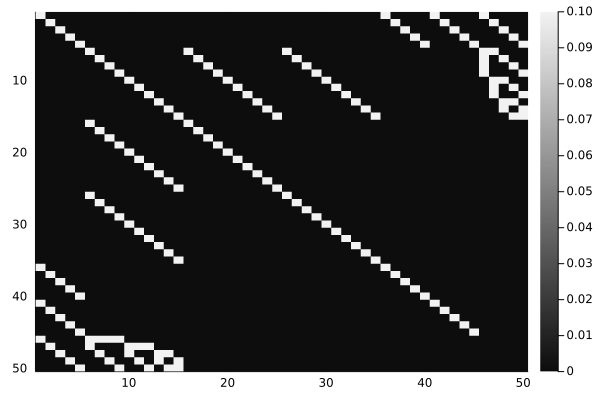

In [120]:
using Plots

heatmap((abs.(∂K_xT) .> 0)[1:end, 1:end], yflip=true, c=:grays, clim=(0, 0.1))

# Jacobian via manual computation

In [124]:
using CarbonNetworks: compute_jacobian

J = Matrix(compute_jacobian(params, x))

error = J - ∂K_xT'

@show norm(error)
@show maximum(error)

norm(error) = 0.002513666016368918
maximum(error) = 0.0014115611165570064


0.0014115611165570064

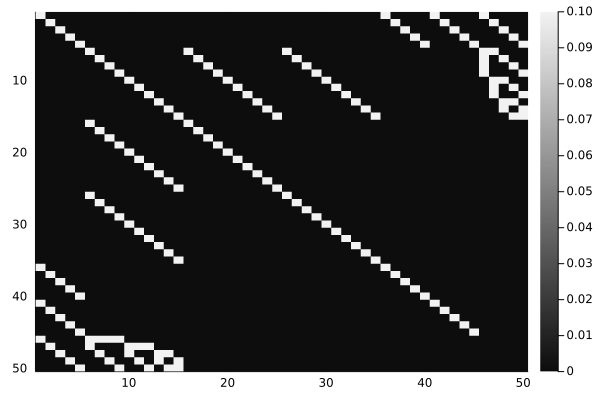

In [122]:
heatmap((abs.(J) .> 0)[1:end, 1:end], yflip=true, c=:grays, clim=(0, 0.1))